## Self-driving Car Project 5: Vehicle Detection and Tracking

In [1]:
# Import libraries
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import glob
%matplotlib inline
import time

# Libaries for video 
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Libaries for machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import blob_dog, blob_log, blob_doh



## 0. Load data

### Load image directionary

In [2]:
# prepare cars and non-cars image, set file directary
cars = []
notcars = []

images = glob.glob('/Users/daruizhang/Documents/vehicles/KITTI_extracted/*.png') # cars
for image in images:
    cars.append(image)

images = glob.glob('/Users/daruizhang/Documents/non-vehicles/Extras/*.png') # noncars
for image in images:
    notcars.append(image)


### Data summary

In [3]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

Car images:     5966
Non-car images: 5766
Image size:     (64, 64, 3)
Data type:      float32


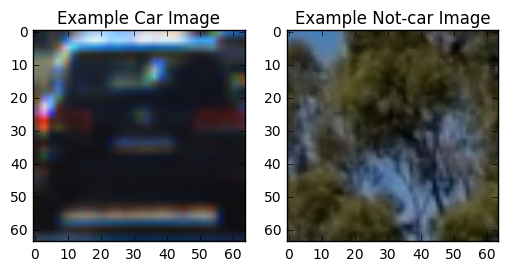

In [4]:
# Basic data summary
data_info = data_look(cars, notcars)
print('Car images:    ', data_info["n_cars"])
print('Non-car images:', data_info["n_notcars"])
print('Image size:    ', data_info["image_shape"])
print('Data type:     ', data_info["data_type"])


# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
noncar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(noncar_image)
plt.title('Example Not-car Image')

## 1. Define Features

In [5]:
image_rgb = np.uint8(car_image*255)# convert to 255
image_hls = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HLS) # convert it to HLS

### Spatial features

In [6]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    spatial_features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return spatial_features 

Spatial features size: (144,)


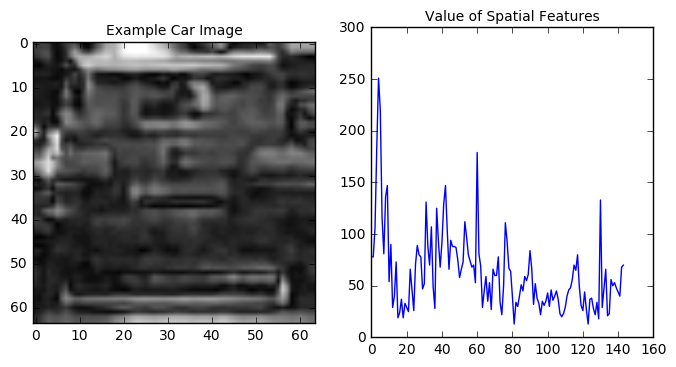

In [9]:
# test if the funtion works
# set tuning parameters
spatial = 12

# extract spatial features
# work on the satuation channel
spatial_features = bin_spatial(image_hls[:,:,2], size=(spatial, spatial))
print('Spatial features size:', spatial_features.shape)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
ax1.imshow(image_hls[:,:,2],cmap='gray')
ax1.set_title('Example Car Image', fontsize=10)
ax2.plot(spatial_features)
ax2.set_title('Value of Spatial Features', fontsize=10)


### Color Histogram Features

In [125]:
def color_hist(img, nbins=32, bins_range=(0, 256),hist_vec=True):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    
    if hist_vec == False:
        # Return the individual histograms, bin_centers and feature vector    
        return rhist, ghist, bhist, bin_centers, hist_features
    else:
        # only return feature vector
        return hist_features

color hist features size: (96,)


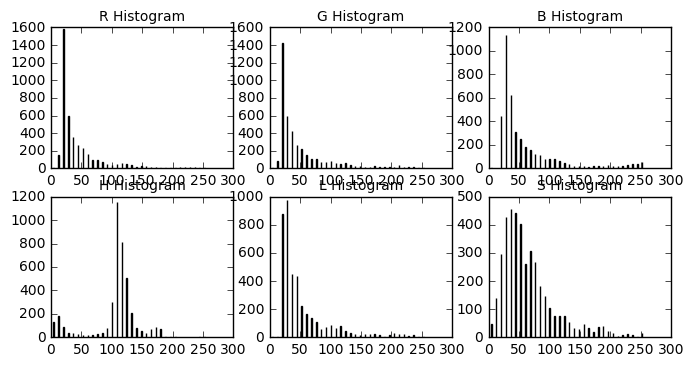

In [126]:
# set tunning parameter
histbin = 32 #number of bins

rh, gh, bh, bincen, feature_vec1 = color_hist(image_rgb, nbins=histbin,
                                              bins_range=(0, 256),hist_vec=False)
hh, lh, sh, bincen, feature_vec2 = color_hist(image_hls, nbins=histbin,
                                              bins_range=(0, 256),hist_vec=False)

print('color hist features size:', feature_vec1.shape)

# Visualize histogram
f, ((ax1, ax2,ax3),(ax4, ax5,ax6) )= plt.subplots(2, 3, figsize=(8,4))

ax1.bar(bincen, rh[0])
ax1.set_title('R Histogram', fontsize=10)

ax2.bar(bincen, gh[0])
ax2.set_title('G Histogram', fontsize=10)


ax3.bar(bincen, bh[0])
ax3.set_title('B Histogram', fontsize=10)

ax4.bar(bincen, hh[0])
ax4.set_title('H Histogram', fontsize=10)

ax5.bar(bincen, lh[0])
ax5.set_title('L Histogram', fontsize=10)

ax6.bar(bincen, sh[0])
ax6.set_title('S Histogram', fontsize=10)


### HOG feature

In [19]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

Hog features shape: (5, 5, 2, 2, 9)
Flatterned Hog features size: (900,)


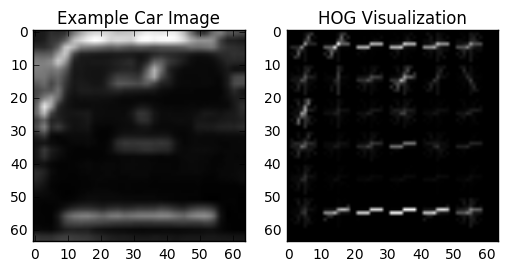

In [20]:
# test if the feature work
image_gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY) # convert to gray scale
# work on grey scale image

# Define HOG parameters
orient = 9
pix_per_cell = 10
cell_per_block = 2

# Call our function with vis=True to see an image output, 
# feature_vec=False to get the feature dimension
hog_features, hog_image = get_hog_features(image_gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# flattern the feature to create the feature vector
hog_1d = np.ravel(hog_features) 

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image_gray, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

# test the funtion
print('Hog features shape:', hog_features.shape)
print('Flatterned Hog features size:', hog_1d.shape)

### Extract featuress

In [127]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, spatial_size=(32, 32),
                     hist_bins=32, hist_range=(0, 256),
                     orient = 9,pix_per_cell = 8,cell_per_block=2):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        
        image_rgb = np.uint8(image*255)# convert to 255
        
        # apply color conversion if other than 'RGB'  
        image_hls = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HLS)# convert it to HLS
        image_gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
        
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(image_hls[:,:,2], size=spatial_size)
        
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(image_hls, nbins=hist_bins, 
                                   bins_range=hist_range, hist_vec=True)
        
        # Call get_hog_features() with vis=False, feature_vec=True
        hog_features = get_hog_features(image_gray, orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features,hog_features)))
        
    # Return list of feature vectors
    return features

In [128]:
# define tunning parameters
spatial = 10

# color hist parameters
histbin = 32

# Define HOG parameters
orient = 9
pix_per_cell = 10
cell_per_block = 2

# extract feature from car images
car_features = extract_features(cars, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256),
                        orient = orient,pix_per_cell = pix_per_cell,
                        cell_per_block=cell_per_block)

# extract feature noncar car images
notcar_features = extract_features(notcars, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256),
                        orient = orient,pix_per_cell = pix_per_cell,
                        cell_per_block=cell_per_block)

X = np.vstack((car_features, notcar_features)).astype(np.float32)   
print("Number of data:    ",X.shape[0])
print("Number of features:",X.shape[1])

Number of data:     11732
Number of features: 1096


### Feature normalization

In [153]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
#X_scaler = MinMaxScaler().fit(X)
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

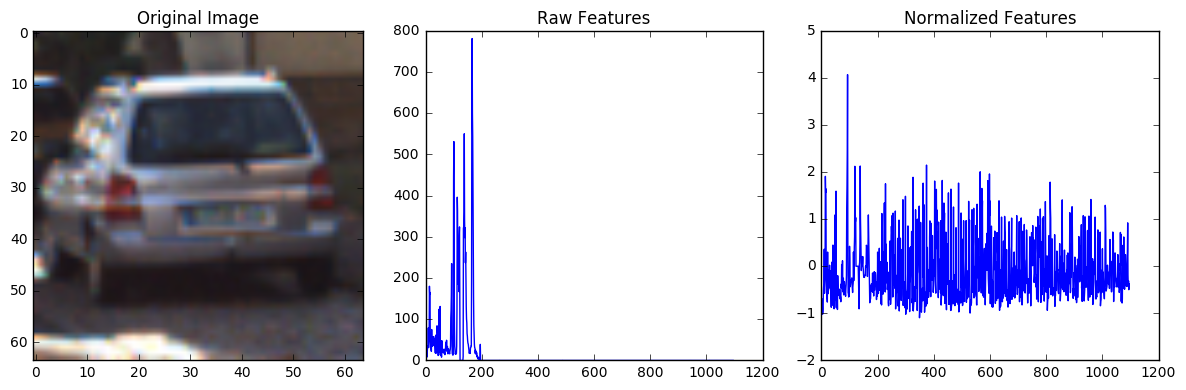

In [154]:
# plot feature normalization
car_ind = np.random.randint(0, len(cars))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

### split trainign and test set

In [155]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)

X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Training set:', X_train.shape[0])
print('Test set    :', X_test.shape[0])


Training set: 9385
Test set    : 2347


## 2. Define classifier

### Train a classifier

In [156]:
# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')


1.95 Seconds to train SVC...


### Test the classifier

In [157]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Test Accuracy of SVC =  0.9991
My SVC predicts:  [ 0.  1.  1.  1.  0.  0.  0.  0.  1.  1.]
For these 10 labels:  [ 0.  1.  1.  1.  0.  0.  0.  0.  1.  1.]
0.00238 Seconds to predict 10 labels with SVC


## 3.Define Sliding Window

### Draw boxes

In [29]:
# draw boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

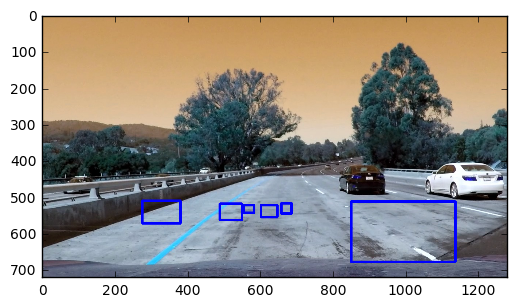

In [30]:
# test if the function works
# Here are the bounding boxes I used
bboxes = [((275, 572), (380, 510)), ((488, 563), (549, 518)), ((554, 543), (582, 522)), 
          ((601, 555), (646, 522)), ((657, 545), (685, 517)), ((849, 678), (1135, 512))]

# load an image
img1 = cv2.imread('test_images/test1.jpg')
img_box = draw_boxes(img1, bboxes, color=(0, 0, 255), thick=6)
plt.imshow(img_box)

### sliding window

In [31]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


In [32]:
img1.shape

(720, 1280, 3)

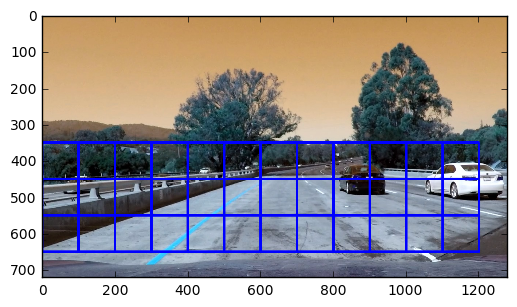

In [33]:
# test the if the funciton is right

# max
x_start_stop =[0, 1280]
y_start_stop =[350, 700]
xy_window = (200, 200)
windows = slide_window(img1, x_start_stop= x_start_stop, y_start_stop = y_start_stop, 
                    xy_window= xy_window, xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(img1, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

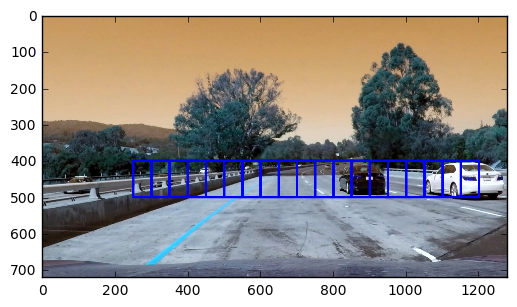

In [34]:
# Define a serial of searching

# minimum 
x_start_stop =[250, 1200]
y_start_stop =[400, 500]
xy_window = (100, 100)

windows = slide_window(img1, x_start_stop= x_start_stop, y_start_stop = y_start_stop, 
                    xy_window= xy_window, xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(img1, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

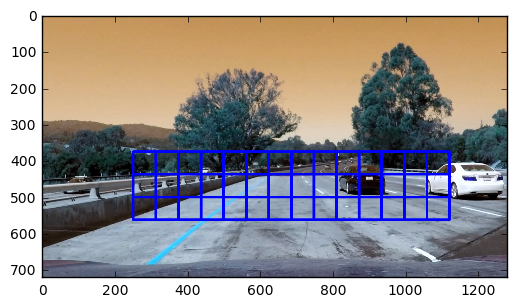

In [35]:
# median  
x_start_stop =[250, 1150]
y_start_stop =[375, 575]
xy_window = (125, 125)

windows = slide_window(img1, x_start_stop= x_start_stop, y_start_stop = y_start_stop, 
                    xy_window= xy_window, xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(img1, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

In [36]:
# the minimum window size
x_min =[250, 1200]
y_min =[400, 500]
xy_min = (100, 100)

# the maxium window size
x_max =[0, 1280]
y_max =[350, 700]
xy_max = (200, 200)

# intermedian windows
n = 4
x = []
y = []
xy =[]
for i in range(n):
    x_start_stop =[int(x_min[0] + i*(x_max[0]-x_min[0])/(n-1)), 
                   int(x_min[1] + i*(x_max[1]-x_min[1])/(n-1))]
    y_start_stop =[int(y_min[0] + i*(y_max[0]-y_min[0])/(n-1)), 
                   int(y_min[1] + i*(y_max[1]-y_min[1])/(n-1))]
    xy_window    =[int(xy_min[0] + i*(xy_max[0]-xy_min[0])/(n-1)), 
                   int(xy_min[1] + i*(xy_max[1]-xy_min[1])/(n-1))]
    x.append(x_start_stop)
    y.append(y_start_stop)
    xy.append(xy_window)
 

[166, 1226]
[383, 566]
[133, 133]


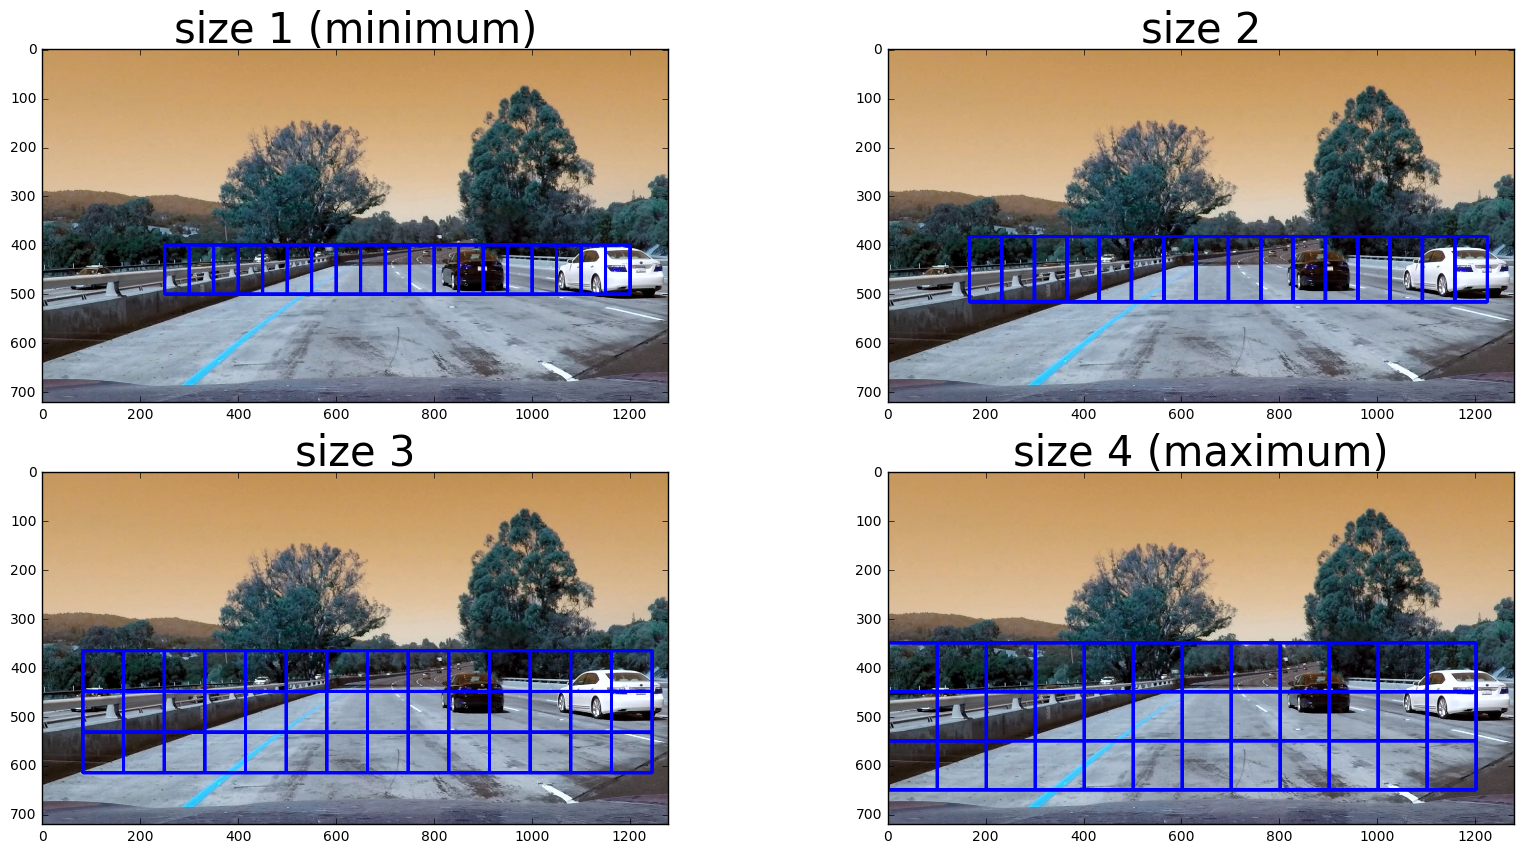

In [37]:
# visualize different window size
x_start_stop = x[1]
y_start_stop = y[1]
xy_window = xy[1]
print(x_start_stop)
print(y_start_stop)
print(xy_window)

windows1 = slide_window(img1, x_start_stop= x[0], y_start_stop = y[0], 
                    xy_window= xy[0], xy_overlap=(0.5, 0.5))
windows2 = slide_window(img1, x_start_stop= x[1], y_start_stop = y[1], 
                    xy_window= xy[1], xy_overlap=(0.5, 0.5))
windows3 = slide_window(img1, x_start_stop= x[2], y_start_stop = y[2], 
                    xy_window= xy[2], xy_overlap=(0.5, 0.5))
windows4 = slide_window(img1, x_start_stop= x[3], y_start_stop = y[3], 
                    xy_window= xy[3], xy_overlap=(0.5, 0.5))
                       
window_img1 = draw_boxes(img1, windows1, color=(0, 0, 255), thick=6)
window_img2 = draw_boxes(img1, windows2, color=(0, 0, 255), thick=6)                    
window_img3 = draw_boxes(img1, windows3, color=(0, 0, 255), thick=6)                    
window_img4 = draw_boxes(img1, windows4, color=(0, 0, 255), thick=6)                    

f, ((ax1, ax2),(ax3, ax4) )= plt.subplots(2, 2, figsize=(20,10))
ax1.imshow(window_img1)
ax1.set_title('size 1 (minimum)', fontsize=30)
ax2.imshow(window_img2)
ax2.set_title('size 2', fontsize=30)
ax3.imshow(window_img3)
ax3.set_title('size 3', fontsize=30)
ax4.imshow(window_img4)
ax4.set_title('size 4 (maximum)', fontsize=30)

In [38]:
print(windows3)

[((83, 366), (249, 532)), ((166, 366), (332, 532)), ((249, 366), (415, 532)), ((332, 366), (498, 532)), ((415, 366), (581, 532)), ((498, 366), (664, 532)), ((581, 366), (747, 532)), ((664, 366), (830, 532)), ((747, 366), (913, 532)), ((830, 366), (996, 532)), ((913, 366), (1079, 532)), ((996, 366), (1162, 532)), ((1079, 366), (1245, 532)), ((83, 449), (249, 615)), ((166, 449), (332, 615)), ((249, 449), (415, 615)), ((332, 449), (498, 615)), ((415, 449), (581, 615)), ((498, 449), (664, 615)), ((581, 449), (747, 615)), ((664, 449), (830, 615)), ((747, 449), (913, 615)), ((830, 449), (996, 615)), ((913, 449), (1079, 615)), ((996, 449), (1162, 615)), ((1079, 449), (1245, 615))]


In [39]:
print(windows3[1])

((166, 366), (332, 532))


In [40]:
# preprocess the image by crop the window, and resize
def preprocess(img,window):
    # crop the image
    img_crop = img[window[0][1]:window[1][1], window[0][0]:window[1][0]]
    # resize the image to 64 by 64
    img_resized = cv2.resize(img_crop, (64, 64))
    return img_resized


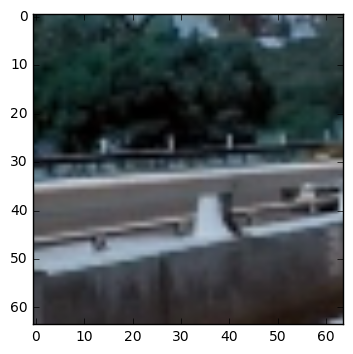

In [41]:
# test if the function works
img = preprocess(img1,windows3[1])
plt.imshow(img)

In [144]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_images_features(img, windows, spatial_size=(32, 32),
                     hist_bins=32, hist_range=(0, 256),
                     orient = 9,pix_per_cell = 8,cell_per_block=2):
    # Create a list to append feature vectors to
    features = []
    
    for n in range(len(windows)):
        # Read in each one by one
        image = preprocess(img,windows[n])

        # apply color conversion if other than 'RGB'  
        HLS_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(HLS_image[:,:,2], size=spatial_size)

        # Apply color_hist() also with a color space option now
        hist_features = color_hist(image_hls, nbins=hist_bins,
                                   bins_range=hist_range,hist_vec=True)


        # Call get_hog_features() with vis=False, feature_vec=True
        hog_features = get_hog_features(gray_image, orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)

        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features,hog_features)))
    # scale
    scaled_features = X_scaler.transform(features)

    # Return list of feature vectors
    return scaled_features

In [159]:
spatial = 10

# color hist parameters
histbin = 32

# Define HOG parameters
orient = 9
pix_per_cell = 10
cell_per_block = 2

img_features = extract_images_features(img1, windows, spatial_size=(spatial, spatial),
                     hist_bins= histbin, hist_range=(0, 256),
                     orient = orient,pix_per_cell = pix_per_cell,cell_per_block=cell_per_block)

In [160]:
# prediction
svc.predict(img_features)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.])

## Video pipline

In [ ]:
# video pipline
def process_img(img):
    # Here are the bounding boxes I used
    bboxes = [((275, 572), (380, 510)), ((488, 563), (549, 518)), ((554, 543), (582, 522)), 
          ((601, 555), (646, 522)), ((657, 545), (685, 517)), ((849, 678), (1135, 512))]

    img_box = draw_boxes(img, bboxes, color=(0, 0, 255), thick=6)

    return img_box

In [ ]:
#process on a video

white_output = 'project_video_after.mp4'
#clip1 = VideoFileClip("/Users/daruizhang/Documents/CarND_P4_Video/project_video.mp4")
#clip1 = VideoFileClip("/Users/daruizhang/Documents/CarND_P4_Video/challenge_video.mp4")
clip1 = VideoFileClip("/Users/daruizhang/Documents/CarND_P4_Video/harder_challenge_video.mp4")

white_clip = clip1.fl_image(process_img) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))